# SuperstoreSalesPredictor

This Jupyter Notebook analyzes Superstore sales data made available on [Kaggle](https://www.kaggle.com/jr2ngb/superstore-data).  This machine learning sales predictor uses time series analysis to precict a year of sales.  It was created for INFO 659 at Drexel University for the Fall 2021-2022 Quarter.  This `.ipynb` file -- and all relevant documentation -- is available on [Github](https://github.com/zachcarlson/SuperstoreSalesPredictor)

The `SuperstoreSalesPredictor` project was coded in both Python and R.

## Group Information

### Team Members:

- Zach Carlson, zc378@drexel.edu
- Sarah Haley, slh54@drexel.edu
- Nancy Melucci, njm99@drexel.edu

## Importing Data and Preprocessing
### Import Packages, fonts, and functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
FILE_PATH = "/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/superstore_dataset2011-2015.csv" #if using google colab
# FILE_PATH = "./data/superstore_dataset2011-2015.csv" #if using Jupyter notebook

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
import warnings

pd.set_option('max_columns', 25) #some columns will be truncated otherwise, setting to number of columns in sales

sns.set_style("ticks")
sns.set(font_scale = 1.5)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
font = {'family': 'sans-serif',
        'size'  : 15}

matplotlib.rc('font', **font)

In [5]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

### Import Data and Pre-processing

In [6]:
sales_raw = pd.read_csv(FILE_PATH, 
                    encoding = "latin")

In [7]:
sales_raw.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,NaN,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,Hungary,NaN,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,NaN,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [8]:
sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [9]:
sales_raw.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


#### Observations:

- There are 51,290 instances with 24 features.
- Dates are in `DD/MM/YYYY` format.
- Features are mostly `object`, with five `float64` and two `int64` features.  Datetime columns need to be converted accordingly.
- There are 41,296 missing values from `Postal Code`.  This is because the `Postal Code` is only present for U.S. purchases.

We'll save a copy of `sales_raw` in case we want to utilize `Postal Code` later.  However, for sales-focused prediction, it won't be necessary:

In [10]:
sales = sales_raw.copy()
sales = sales.drop("Postal Code", axis = 1) #axis=1 for column
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Market          51290 non-null  object 
 12  Region          51290 non-null  object 
 13  Product ID      51290 non-null  object 
 14  Category        51290 non-null  object 
 15  Sub-Category    51290 non-null  object 
 16  Product Name    51290 non-null  object 
 17  Sales           51290 non-null 

In [11]:
#convert datetime columns to datetime objects
sales['Order Date'] = pd.to_datetime(sales['Order Date'], dayfirst=True)
sales['Ship Date'] = pd.to_datetime(sales['Ship Date'], dayfirst=True)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Market          51290 non-null  object        
 12  Region          51290 non-null  object        
 13  Product ID      51290 non-null  object        
 14  Category        51290 non-null  object        
 15  Su

In [12]:
#Get only order date, sales, and profit
sales = sales.loc[:, ["Order Date", "Sales", "Profit"]]

#Set date column to index
sales.set_index('Order Date', inplace = True)

In [13]:
#confirm we have a Datetime series object
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51290 entries, 2011-01-01 to 2014-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   51290 non-null  float64
 1   Profit  51290 non-null  float64
dtypes: float64(2)
memory usage: 1.2 MB
None


## EDA

### Raw Visualization

Let's start by visualizing the `Sales` and `Profit` from 2011-2015:

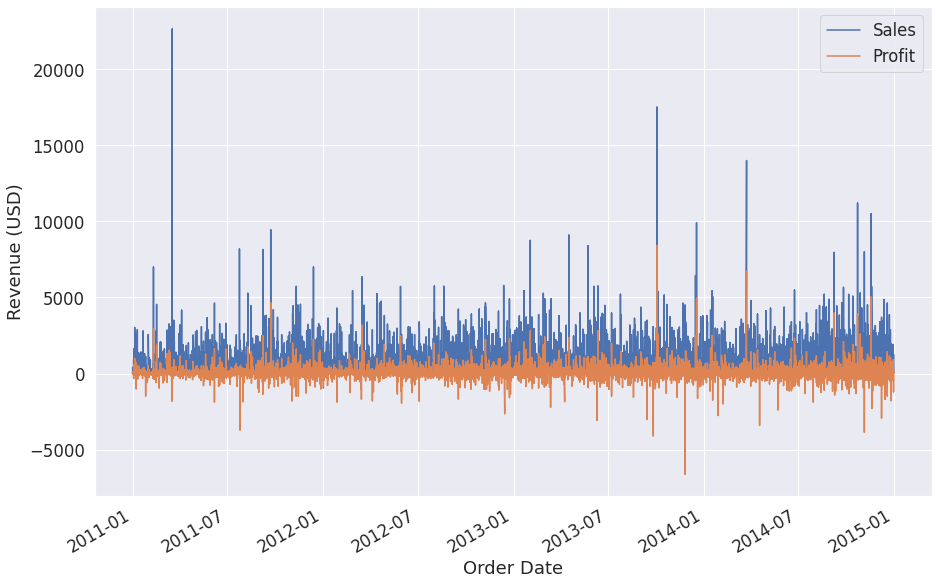

In [14]:
ax = sales.plot()
plt.gcf().set_size_inches(15, 10)
ax.set_ylabel("Revenue (USD)")
plt.show()

Let's see how the data compares year to year by overlapping the time series data:

**Observations:**

- Raw visualizations and yearly overlap are hard to read.  More will need to be done to improve it.  Optimizing frequency of the time series period and working with rolling averages may help.

### Frequency Optimization

It is pretty challenging to see anything on these plots.  At the very least, let's consolidate `Sales` and `Profits` data from each day.

We'll also export these consolidated datasets in case we want to use them for analysis later.

In [15]:
sales = sales.groupby("Order Date").sum()
sales.to_csv("/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/initial_sales.csv", header=True)
sales

,Sales,Profit
Order Date,,
2011-01-01,808.56300,198.87300
2011-01-02,314.22000,3.12000
2011-01-03,4503.53720,184.59720
2011-01-04,2808.87024,635.12344
2011-01-05,3662.31000,1053.36990
...,...,...
2014-12-27,13421.26376,-916.64004
2014-12-28,1647.17400,81.06380
2014-12-29,25109.28878,2046.20678


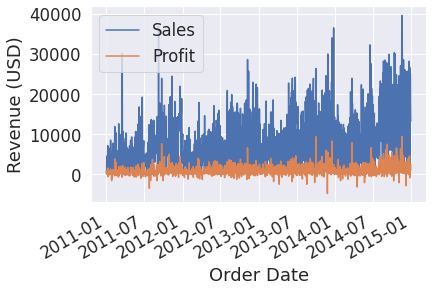

In [16]:
sales.plot()
plt.ylabel("Revenue (USD)")
plt.show()

In [17]:
#Create empty dataframe to store yearly data
sales_by_year = pd.DataFrame()

for year in ["2011", "2012", "2013", "2014"]:
  temp_year = sales.loc[year, ["Sales"]].reset_index(drop = True)
  temp_year.rename(columns={"Sales": year}, inplace = True)
  sales_by_year = pd.concat([sales_by_year, temp_year], axis=1)

sales_by_year

,2011,2012,2013,2014
0,808.56300,10006.6647,9369.15300,3614.03450
1,314.22000,3453.3043,11613.89560,4169.51614
2,4503.53720,2617.8439,5790.96900,11327.62200
3,2808.87024,5662.2250,16266.57344,4705.27370
4,3662.31000,544.5140,5795.99950,426.66000
...,...,...,...,...
356,NaN,4823.0940,3553.03630,13421.26376
357,NaN,10668.5844,426.56000,1647.17400
358,NaN,NaN,14292.38000,25109.28878
359,NaN,NaN,14176.72090,16831.61480


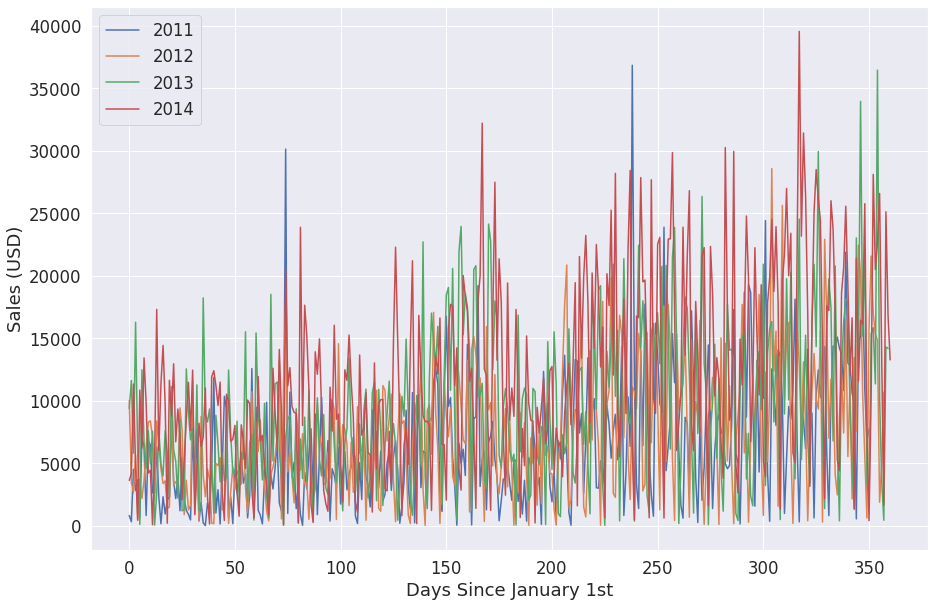

In [18]:
sales_by_year.plot()
plt.gcf().set_size_inches(15, 10)
plt.ylabel("Sales (USD)")
plt.xlabel("Days Since January 1st")
plt.show()

Plotting the `sales` data using a daily frequency `D` still is hard to understand.  Setting the frequency to start-of-month `MS` greatly improves readability.  We'll also include the start-of-year frequency `YS`:

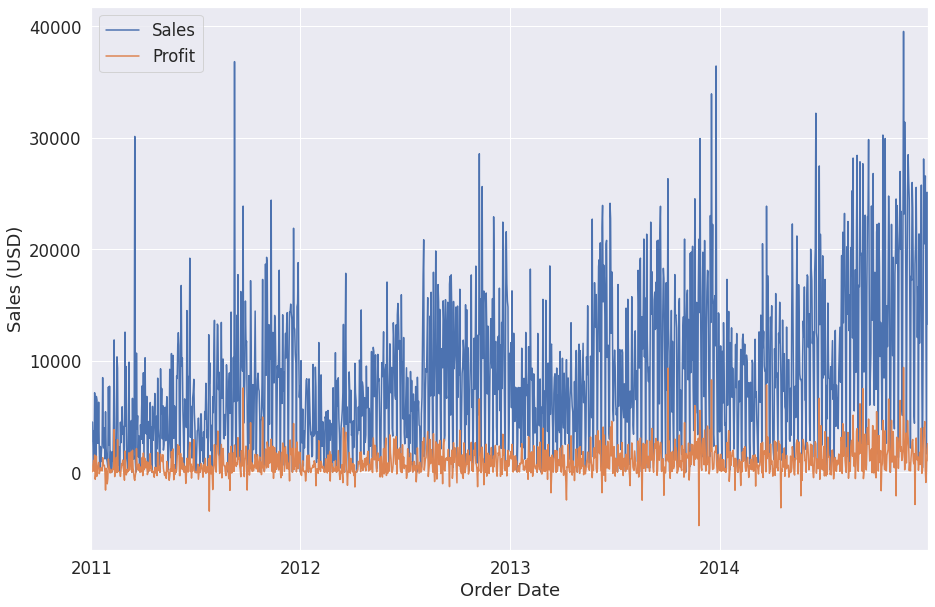

In [19]:
daily_sales = sales.groupby(pd.Grouper(freq='D')).sum()
daily_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.ylabel("Sales (USD)")
plt.show()

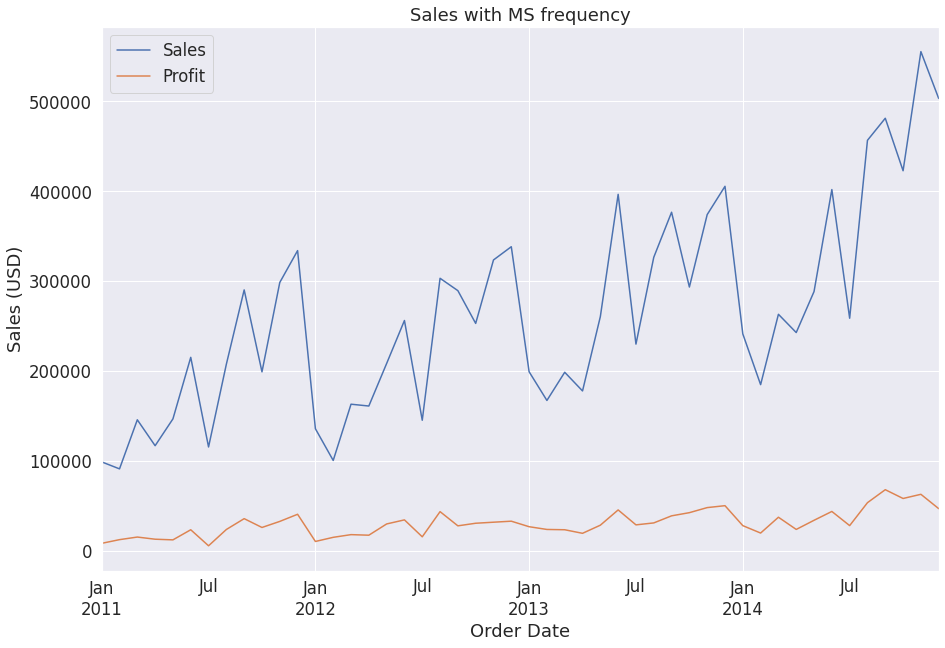

In [20]:
monthly_sales = sales.groupby(pd.Grouper(freq='MS')).sum()
monthly_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales with MS frequency")
plt.ylabel("Sales (USD)")
plt.show()

In [21]:
yearly_sales = sales.groupby(pd.Grouper(freq='YS')).sum()
yearly_sales

,Sales,Profit
Order Date,,
2011-01-01,2.259451e+06,248940.81154
2012-01-01,2.677439e+06,307415.27910
2013-01-01,3.405746e+06,406935.23018
2014-01-01,4.299866e+06,504165.97046


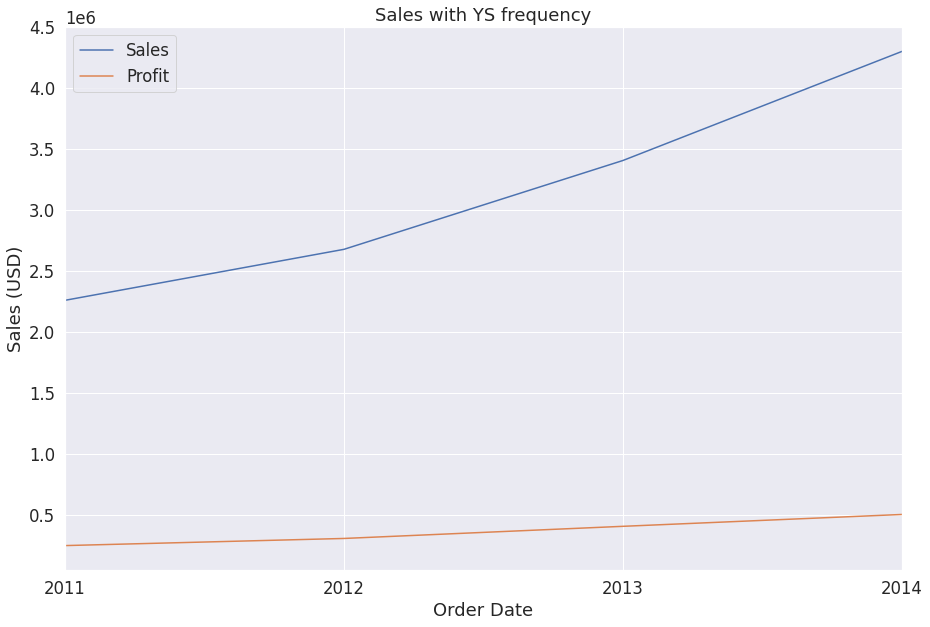

In [22]:
yearly_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales with YS frequency")
plt.ylabel("Sales (USD)")
plt.show()

In [23]:
#export files
daily_sales = daily_sales[["Sales"]]
monthly_sales = monthly_sales[["Sales"]]
yearly_sales = yearly_sales[["Sales"]]
daily_sales.to_csv("/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/daily_sales.csv", header=True)
monthly_sales.to_csv("/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/monthly_sales.csv", header=True)
yearly_sales.to_csv("/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/yearly_sales.csv", header=True)

Let's revisit the year-by-year overlap figure by with the monthly data instead:

In [24]:
#Create empty dataframe to store yearly data
monthly_sales_by_year = pd.DataFrame()

for year in ["2011", "2012", "2013", "2014"]:
  temp_year = monthly_sales.loc[year, ["Sales"]].reset_index(drop = True)
  temp_year.rename(columns={"Sales": year}, inplace = True)
  monthly_sales_by_year = pd.concat([monthly_sales_by_year, temp_year], axis=1)

monthly_sales_by_year

,2011,2012,2013,2014
0,98898.48886,135780.72024,199185.90738,241268.55566
1,91152.15698,100510.21698,167239.65040,184837.35556
2,145729.36736,163076.77116,198594.03012,263100.77262
3,116915.76418,161052.26952,177821.31684,242771.86130
4,146747.83610,208364.89124,260498.56470,288401.04614
5,215207.38022,256175.69842,396519.61190,401814.06310
6,115510.41912,145236.78512,229928.95200,258705.68048
7,207581.49122,303142.94238,326488.78936,456619.94236
8,290214.45534,289389.16564,376619.24568,481157.24370
9,199071.26404,252939.85020,293406.64288,422766.62916


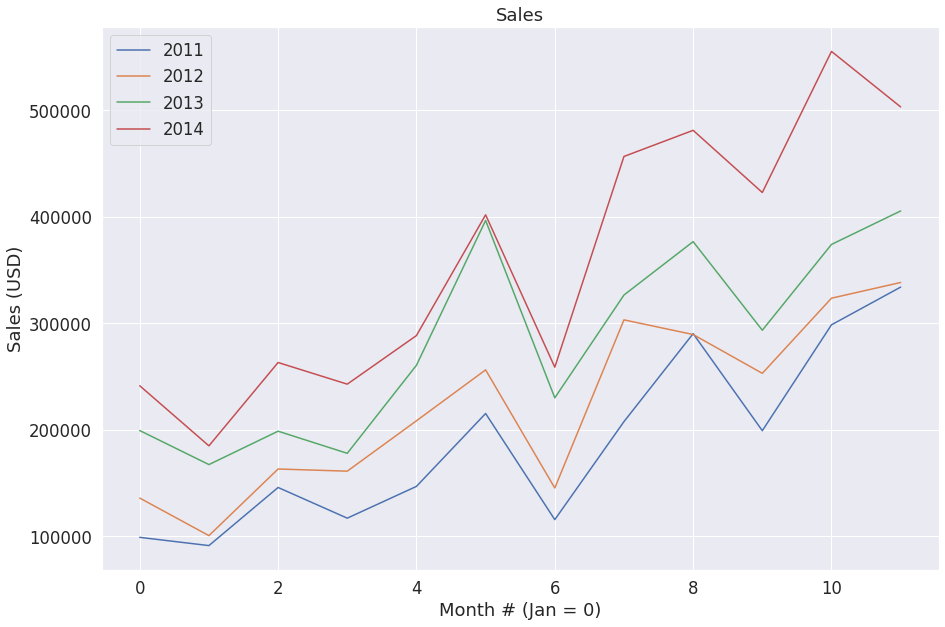

In [25]:
monthly_sales_by_year.plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales")
plt.ylabel("Sales (USD)")
plt.xlabel("Month # (Jan = 0)")
plt.show()

**Observations:**
- There do appear to be yearly spikes around Month 5, 8, and 11-12.  These correspond to the 6th, 9th, and 12th months of the year due to how Python deals with indices, which are **June**, **September**, and **Nov-Dec**.  
- This may be due to the start of buying things for summer months as well as school supplies shopping and holiday shopping in the winter.
- The frequency of month appears best, with daily being too noisy and yearly being too simple.  To ensure this is the best data, we'll look at rolling averages as well.

### Rolling Averages

The daily data is still quite difficult to visualize.  It might be best to do a rolling average.  Let's plot the daily sales and a 7-day rolling average:

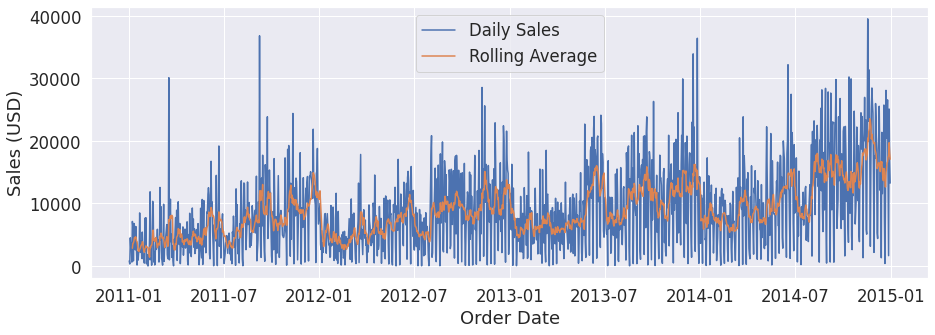

In [26]:
sales['7D_sales'] = sales.Sales.rolling(7).mean()
sales['7D_profit'] = sales.Profit.rolling(7).mean()
plt.gcf().set_size_inches(15, 5)
sns.lineplot(x = sales.index, y = 'Sales', data = sales, label = 'Daily Sales')
sns.lineplot(x = sales.index, y = '7D_sales', data = sales, label = 'Rolling Average', palette=['r'])
plt.ylabel("Sales (USD)")
plt.show()

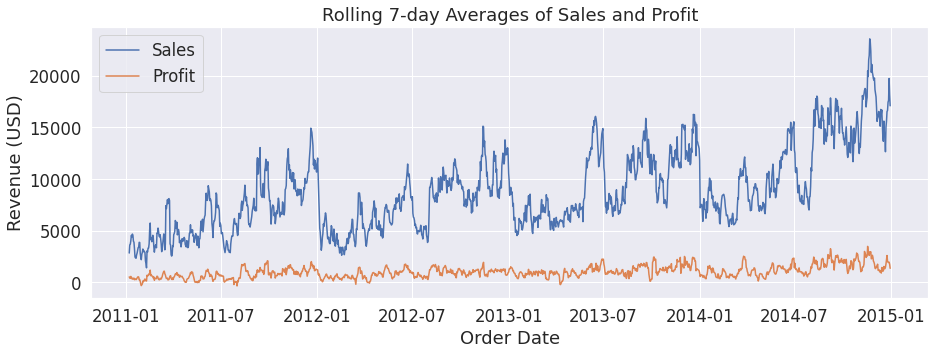

In [27]:
plt.gcf().set_size_inches(15, 5)
sns.lineplot(x = sales.index, y = '7D_sales', data = sales, label = 'Sales')
sns.lineplot(x = sales.index, y = '7D_profit', data = sales, label = 'Profit')

plt.title("Rolling 7-day Averages of Sales and Profit")
plt.ylabel("Revenue (USD)")
plt.show()

Let's see if a 30-day rolling average improves the readability:

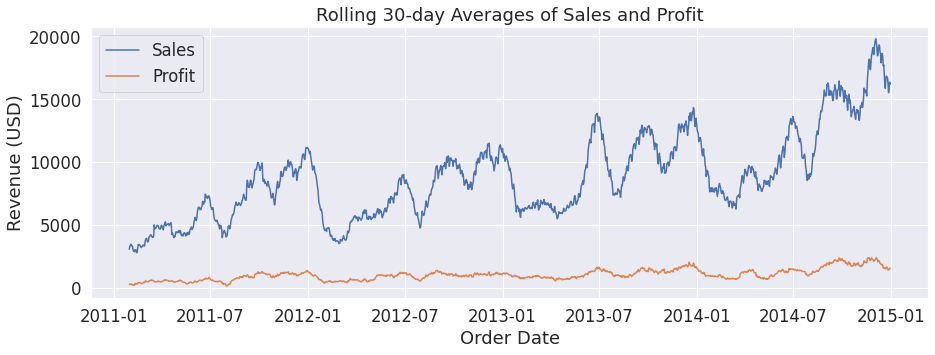

In [28]:
sales['30D_sales'] = sales.Sales.rolling(30).mean()
sales['30D_profit'] = sales.Profit.rolling(30).mean()

sns.lineplot(x = sales.index, y = '30D_sales', data = sales, label = 'Sales')
sns.lineplot(x = sales.index, y = '30D_profit', data = sales, label = 'Profit')

plt.title("Rolling 30-day Averages of Sales and Profit")
plt.gcf().set_size_inches(15, 5)
plt.ylabel("Revenue (USD)")
plt.show()

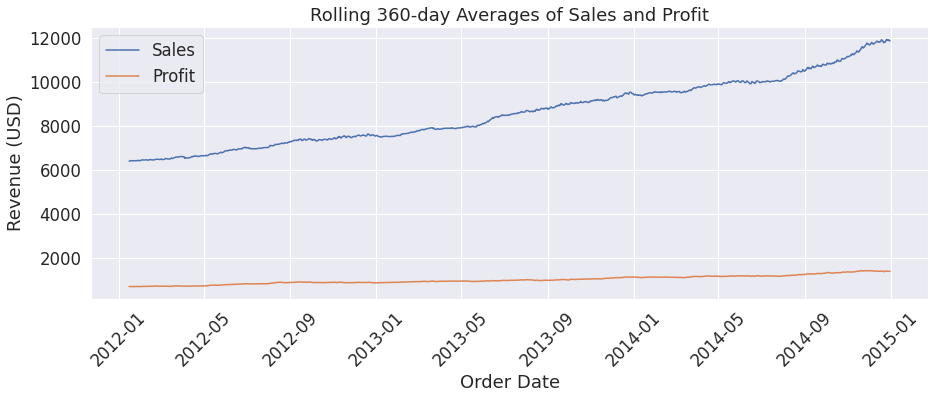

In [29]:
sales['360D_sales'] = sales.Sales.rolling(365).mean()
sales['360D_profit'] = sales.Profit.rolling(365).mean()

sns.lineplot(x = sales.index, y = '360D_sales', data = sales, label = 'Sales')
sns.lineplot(x = sales.index, y = '360D_profit', data = sales, label = 'Profit')

plt.title("Rolling 360-day Averages of Sales and Profit")
plt.gcf().set_size_inches(15, 5)
plt.ylabel("Revenue (USD)")
plt.xticks(rotation=45)
plt.show()

It may appear that profit is stagnant over this time period, however when splitting the data into subplots, it's clear that profit is increasing, however not nearly at the scale of sales:

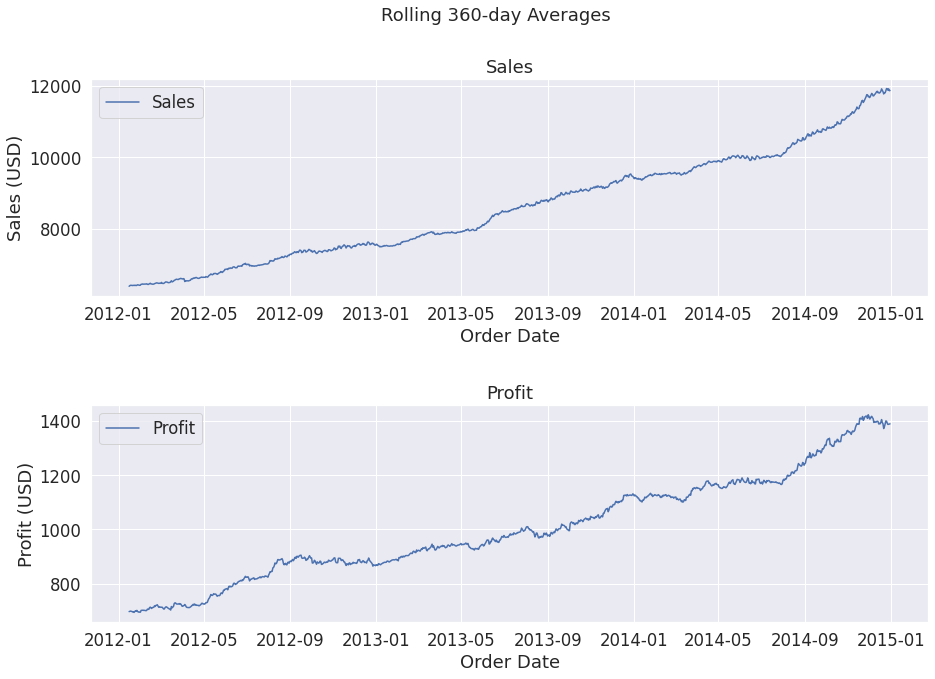

In [30]:
fig, axes = plt.subplots(2, 1)

sns.lineplot(ax = axes[0], x = sales.index, y = '360D_sales', data = sales, label = 'Sales', )
sns.lineplot(ax = axes[1], x = sales.index, y = '360D_profit', data = sales, label = 'Profit', palette='r')

fig.suptitle('Rolling 360-day Averages')
plt.gcf().set_size_inches(15, 10)
plt.subplots_adjust(hspace=0.5)
axes[0].set_title('Sales')
axes[1].set_title('Profit')
axes[0].set_ylabel("Sales (USD)")
axes[1].set_ylabel("Profit (USD)")
plt.show()

It is useful to see the distribution of the rolling average to see how volatile the sales time series actually is:

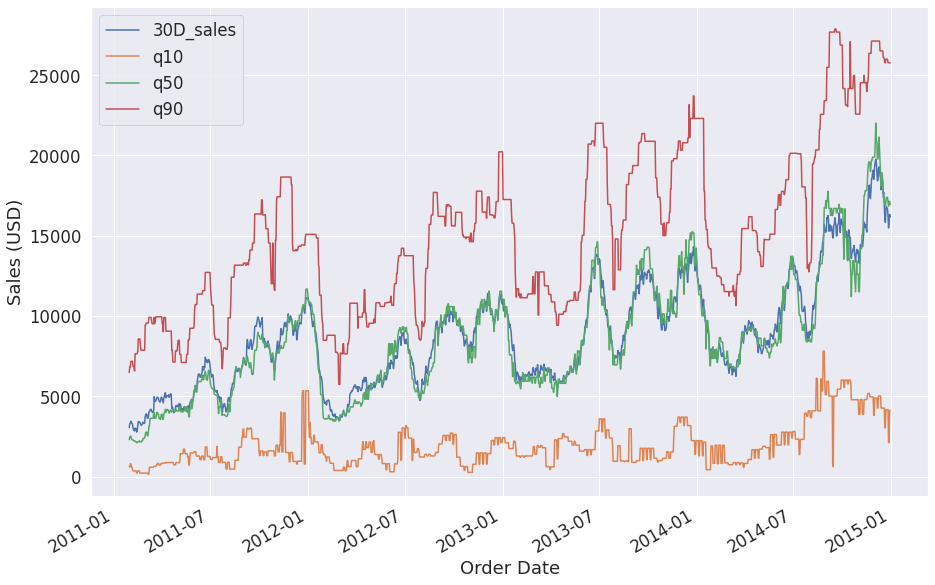

In [31]:
#get subset of data
sales_subset = sales.loc[:,["Sales", "30D_sales"]]

#create rolling average
rolling = sales_subset.Sales.rolling(30)

#calculate quantiles
sales_subset['q10'] = rolling.quantile(0.1).to_frame('q10')
sales_subset['q50'] = rolling.quantile(0.5).to_frame('q50')
sales_subset['q90'] = rolling.quantile(0.9).to_frame('q90')

#plot data
sales_subset[["30D_sales", "q10", "q50", "q90"]].plot()
plt.gcf().set_size_inches(15, 10)
plt.ylabel("Sales (USD)")
plt.show()

Let's create one summary figure with subplots of all the different rolling averages from above:

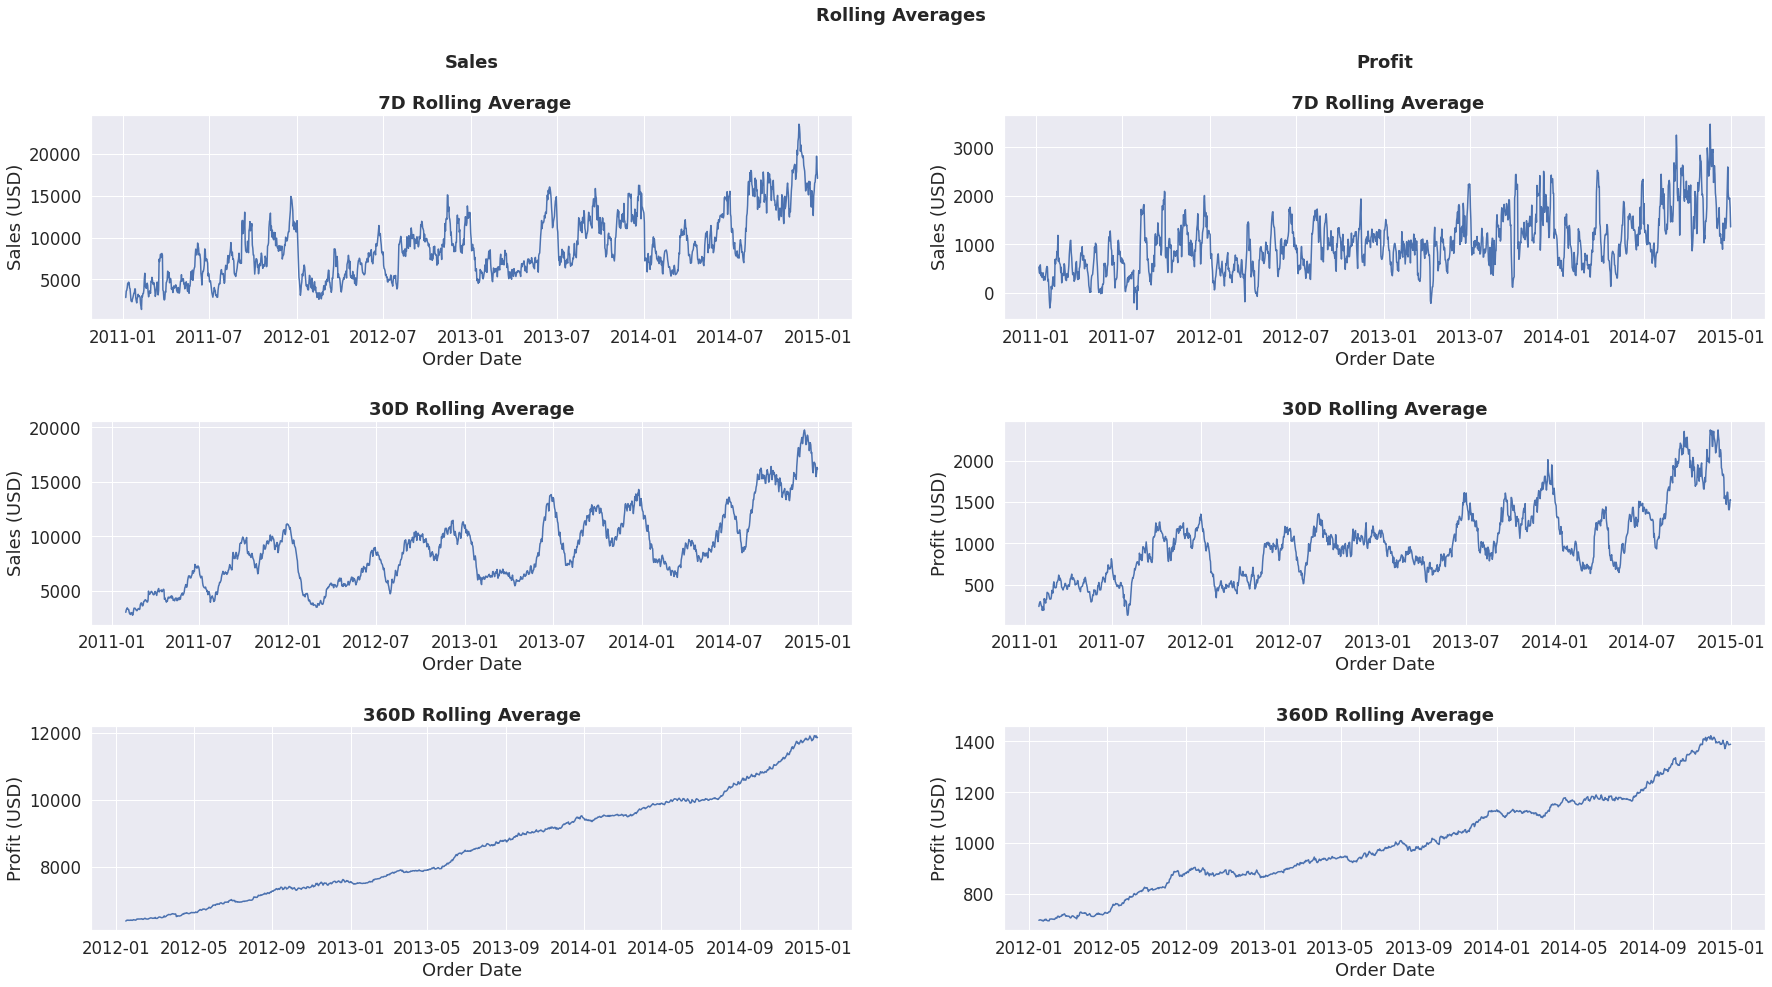

In [32]:
#plot sales percentage change
fig, axes = plt.subplots(3, 2)

sns.lineplot(ax = axes[0, 0], x = sales.index, y = '7D_sales', data = sales)
sns.lineplot(ax = axes[0, 1], x = sales.index, y = '7D_profit', data = sales)
sns.lineplot(ax = axes[1, 0], x = sales.index, y = '30D_sales', data = sales)
sns.lineplot(ax = axes[1, 1], x = sales.index, y = '30D_profit', data = sales)
sns.lineplot(ax = axes[2, 0], x = sales.index, y = '360D_sales', data = sales)
sns.lineplot(ax = axes[2, 1], x = sales.index, y = '360D_profit', data = sales)

fig.suptitle('Rolling Averages', weight='bold')
axes[0,0].set_title("Sales\n\n 7D Rolling Average", weight='bold')
axes[0,1].set_title("Profit\n\n 7D Rolling Average", weight='bold')
axes[1,0].set_title("30D Rolling Average", weight='bold')
axes[1,1].set_title("30D Rolling Average", weight='bold')
axes[2,0].set_title("360D Rolling Average", weight='bold')
axes[2,1].set_title("360D Rolling Average", weight='bold')
axes[0,0].set_ylabel("Sales (USD)")
axes[0,1].set_ylabel("Sales (USD)")
axes[1,0].set_ylabel("Sales (USD)")
axes[1,1].set_ylabel("Profit (USD)")
axes[2,0].set_ylabel("Profit (USD)")
axes[2,1].set_ylabel("Profit (USD)")
plt.gcf().set_size_inches(30, 15)
plt.subplots_adjust(hspace=.5)

**Observations:**

- Out of all the visualization techniques, the 30-day rolling average is the best.  We'll be using that going forward.
- **The rolling 360-day average of sales and profit clearly show an increase in sales and profit overtime, however sales is increase at a scale of almost 10x more.  This conclusion, however, could also have been made with the previous data from `monthly_sales`, etc.**

### Rolling Average Percent Change

Let's look at the monthly and yearly percent changes in sales and profit values:

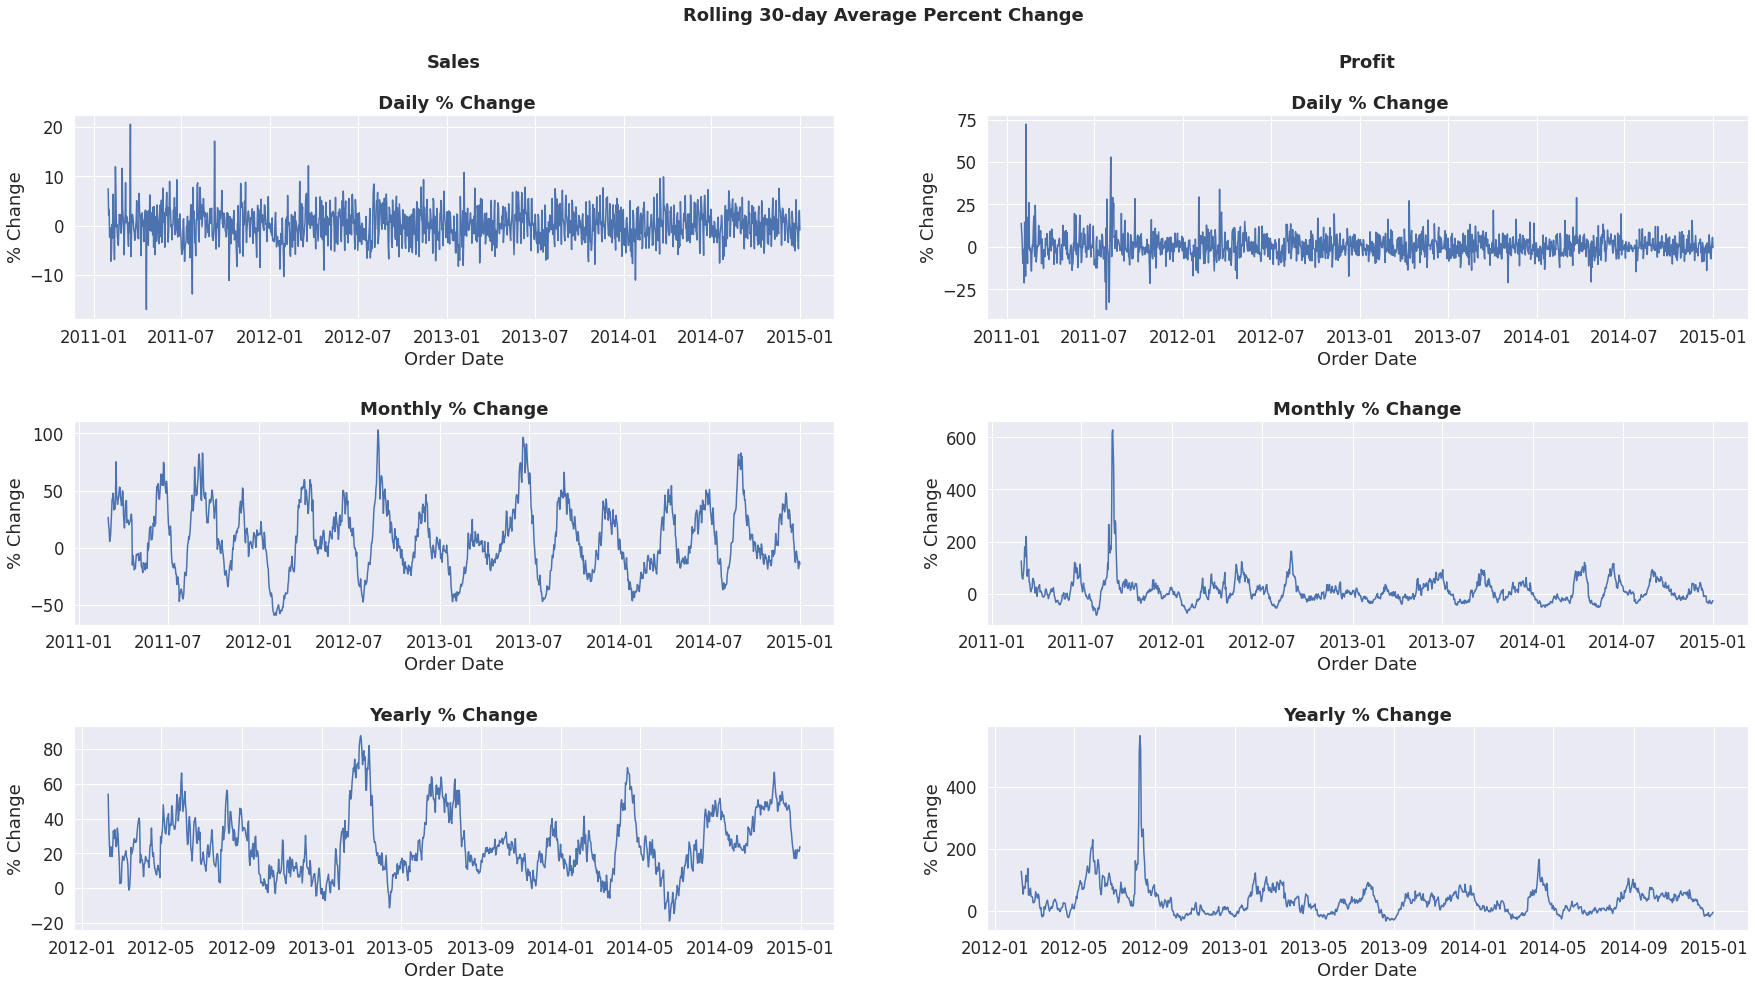

In [33]:
#sales
sales['30D_sales_daily'] = sales['30D_sales'].pct_change(periods = 1).mul(100) #daily
sales['30D_sales_monthly'] = sales['30D_sales'].pct_change(periods = 30).mul(100) #monthly
sales['30D_sales_yearly'] = sales['30D_sales'].pct_change(periods = 360).mul(100) #yearly

#profit
sales['30D_profit_daily'] = sales['30D_profit'].pct_change(periods = 1).mul(100) #daily
sales['30D_profit_monthly'] = sales['30D_profit'].pct_change(periods = 30).mul(100) #monthly
sales['30D_profit_yearly'] = sales['30D_profit'].pct_change(periods = 360).mul(100) #yearly

#plot sales percentage change
fig, axes = plt.subplots(3, 2)

sns.lineplot(ax = axes[0, 0], x = sales.index, y = '30D_sales_daily', data = sales)
sns.lineplot(ax = axes[0, 1], x = sales.index, y = '30D_profit_daily', data = sales)
sns.lineplot(ax = axes[1, 0], x = sales.index, y = '30D_sales_monthly', data = sales)
sns.lineplot(ax = axes[1, 1], x = sales.index, y = '30D_profit_monthly', data = sales)
sns.lineplot(ax = axes[2, 0], x = sales.index, y = '30D_sales_yearly', data = sales)
sns.lineplot(ax = axes[2, 1], x = sales.index, y = '30D_profit_yearly', data = sales)

fig.suptitle('Rolling 30-day Average Percent Change', weight='bold')
axes[0,0].set_title("Sales\n\n Daily % Change", weight='bold')
axes[0,1].set_title("Profit\n\n Daily % Change", weight='bold')
axes[1,0].set_title("Monthly % Change", weight='bold')
axes[1,1].set_title("Monthly % Change", weight='bold')
axes[2,0].set_title("Yearly % Change", weight='bold')
axes[2,1].set_title("Yearly % Change", weight='bold')
axes[0,0].set_ylabel("% Change")
axes[0,1].set_ylabel("% Change")
axes[1,0].set_ylabel("% Change")
axes[1,1].set_ylabel("% Change")
axes[2,0].set_ylabel("% Change")
axes[2,1].set_ylabel("% Change")
plt.gcf().set_size_inches(30, 15)
plt.subplots_adjust(hspace=.5)

**Observations:**

- The day-to-day percent changes in sales are pretty constant around zero.
- The month-to-month and year-to-year percent changes in sales and profit show clear time-based oscillations.

### Correlation Analysis

Looking at the rolling averages, there is clearly some correlation between sales and profit:

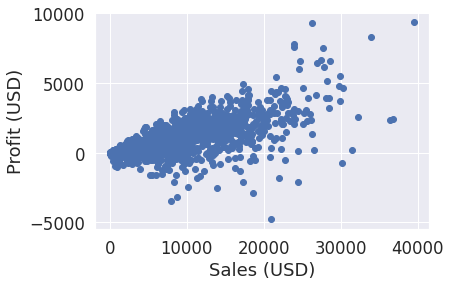

In [34]:
plt.scatter(sales["Sales"], sales["Profit"])
plt.xlabel("Sales (USD)")
plt.ylabel("Profit (USD)")
plt.show()

In [35]:
correlation = sales["Sales"].corr(sales["Profit"])
correlation_7D = sales["7D_sales"].corr(sales["7D_profit"])
correlation_30D = sales["30D_sales"].corr(sales["30D_profit"])
correlation_360D = sales["360D_sales"].corr(sales["360D_profit"])

print("Raw data correlation is:", correlation)
print("7D rolling average correlation is:", correlation_7D)
print("30D rolling average correlation is:", correlation_30D)
print("360D rolling average correlation is:", correlation_360D)

Raw data correlation is: 0.6495587604092661
7D rolling average correlation is: 0.8076641803429069
30D rolling average correlation is: 0.945758520906887
360D rolling average correlation is: 0.9916450642288597


**Observations:**
- As the rolling average gets larger, the correlation between sales and profits gets stronger.

## ARIMA: Manual Configuration

Now that we'll build our model, let's split the data into training and test sets.  The train set will contain the monthly sales data from 2011-2014 and the test set will contain the monthly sales data from 2014-2015.  We'll also save the train and test set for importing later:

In [36]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = monthly_sales[["Sales"]][:36]
test = monthly_sales[["Sales"]][36:]

#export to use for final prediction
train.to_csv("/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/train.csv", header=False)
test.to_csv("/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/test.csv", header=False)

### Order of Differencing (d)

When looking at the 30-day rolling average of sales or the data from `monthly_sales`, it's clear the data is not stationary.  We can confirm this with the Augmented Dickey Fuller test using `adfuller` from `statsmodel.tsa.stattools`.  The null-hypothesis is that the time series is non-stationary.  Thus, a p-value > 0.05 means we fail to reject the null hypothesis and the time series is non-stationary.

In [37]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_sales["Sales"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.618332
p-value: 0.988059


**The p-value is 0.988 and we fail to reject the null hypothesis, the time series is non-stationary.**

We'll do an autocorrelation analysis on the Sales and Profit time series using different rolling averages:

Now let's look at the autocorrelation when using the `monthly_sales` data.  We'll need to use `.dropna()` to remove the missing values on the `.diff()` plots:

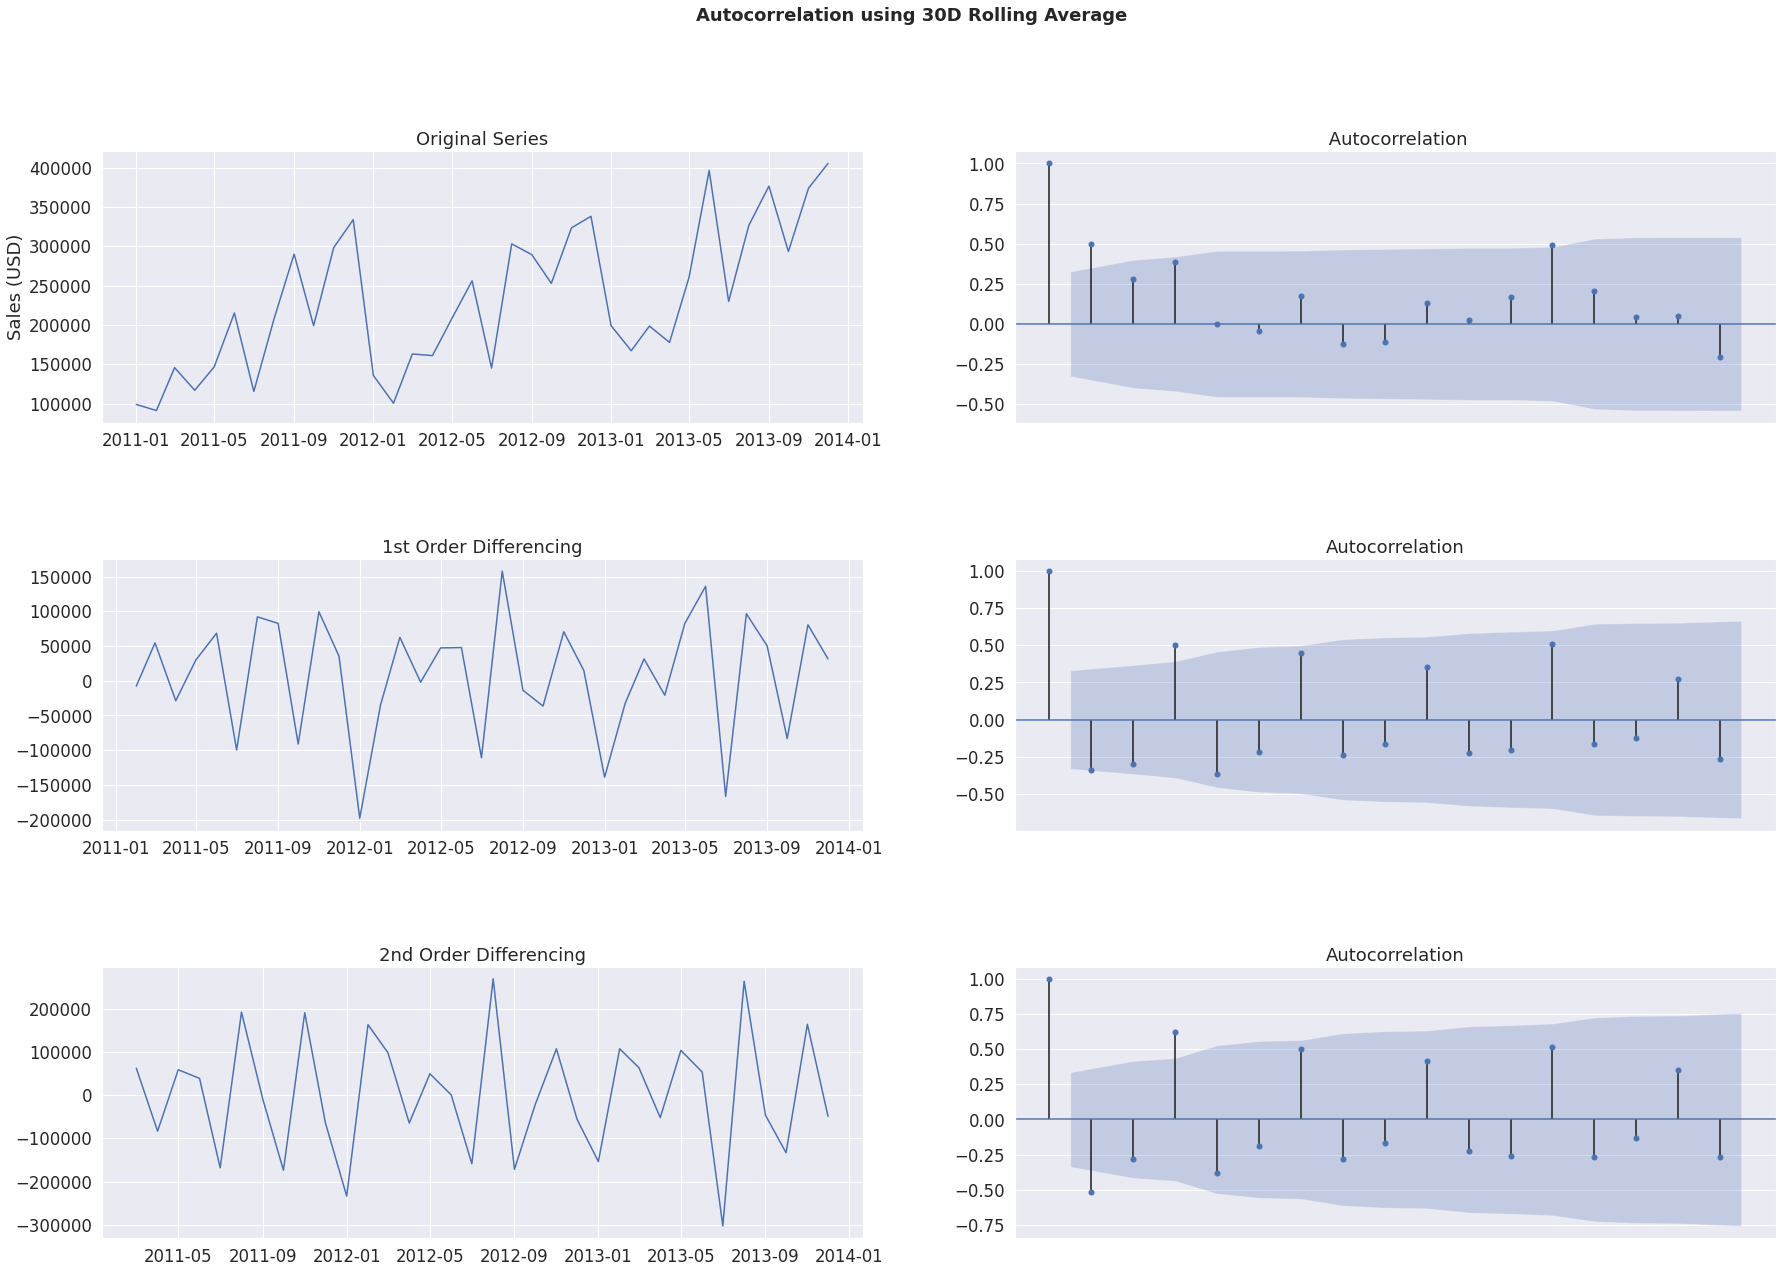

In [38]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2)

#create plot
axes[0, 0].plot(train["Sales"]); axes[0, 0].set_title('Original Series')
plot_acf(train["Sales"], ax=axes[0, 1], title=" Autocorrelation");
axes[1, 0].plot(train["Sales"].diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train["Sales"].diff().dropna(), ax=axes[1, 1], title="Autocorrelation");
axes[2, 0].plot(train["Sales"].diff().diff().dropna()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train["Sales"].diff().diff().dropna(), ax=axes[2, 1], title="Autocorrelation");

#visuals
fig.suptitle('Autocorrelation using 30D Rolling Average', weight='bold')
axes[0,0].set_ylabel("Sales (USD)")
axes[1,0].set_ylabel("")
axes[2,0].set_ylabel("")
axes[0,1].set_xticks([])
axes[1,1].set_xticks([])
axes[2,1].set_xticks([])
plt.gcf().set_size_inches(30, 20)
plt.subplots_adjust(hspace=.5)
plt.show()

**Observations:**
- The p-value of the ADF test is 0.988 and we fail to reject the null hypothesis, the time series is non-stationary.
- 1st order differencing created a stationary time series with a constant mean and variance using a lag of 1 (i.e. `.diff()`).
- Additional differencing was attempted (i.e 2nd order differencing), however it did not improve the autocorrelation (see lag multiples of 3).
- **Order of differencing is 1**

### AR term (p):

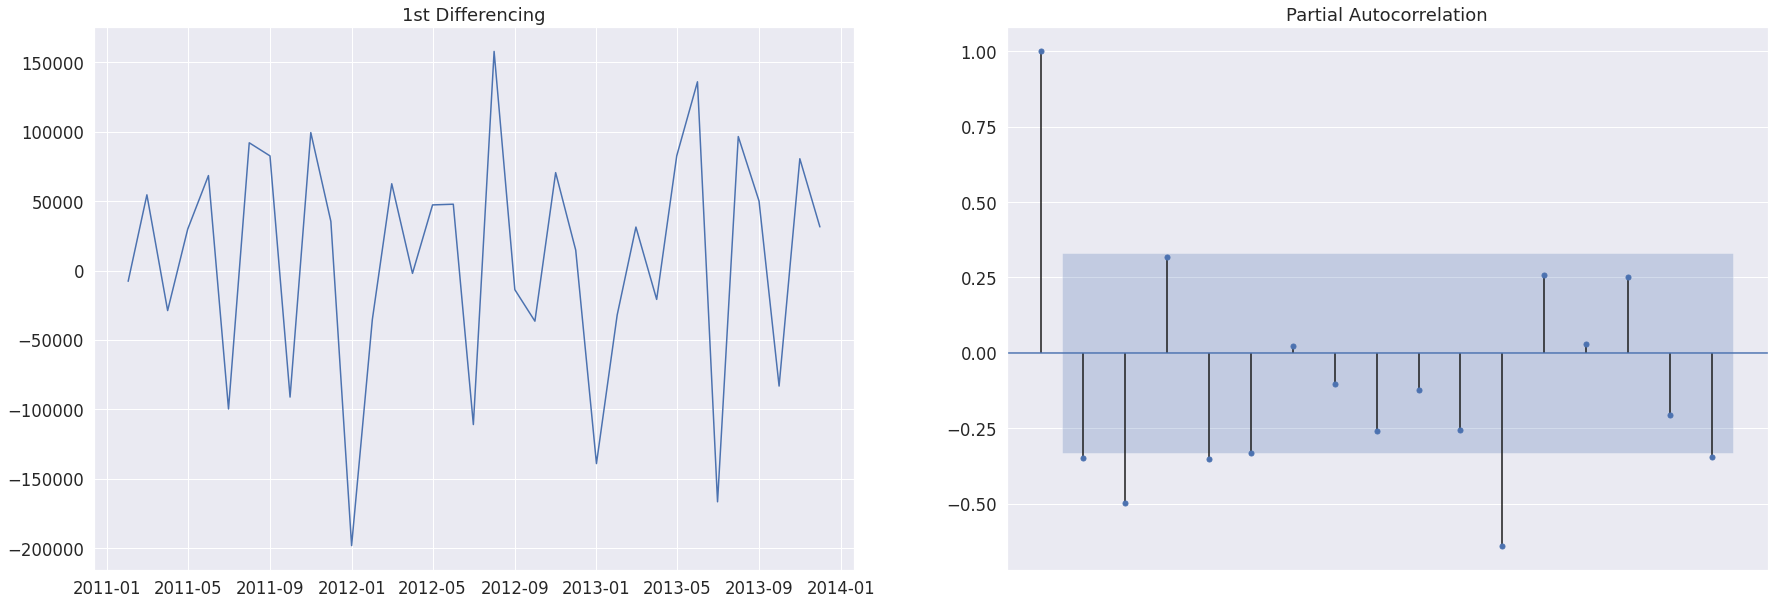

In [39]:
from statsmodels.graphics.tsaplots import plot_pacf

#create figures
fig, axes = plt.subplots(1, 2)
axes[0].plot(train["Sales"].diff()); axes[0].set_title('1st Differencing')
plot_pacf(train["Sales"].diff().dropna(), ax=axes[1])

#visuals
plt.gcf().set_size_inches(30, 10)
plt.xticks([])
plt.show()

**Observations:**
- Lag 12 is significantly different from zero.  However, the other lags are not.  We will conservatively set lag to 2.

### MA term (q):

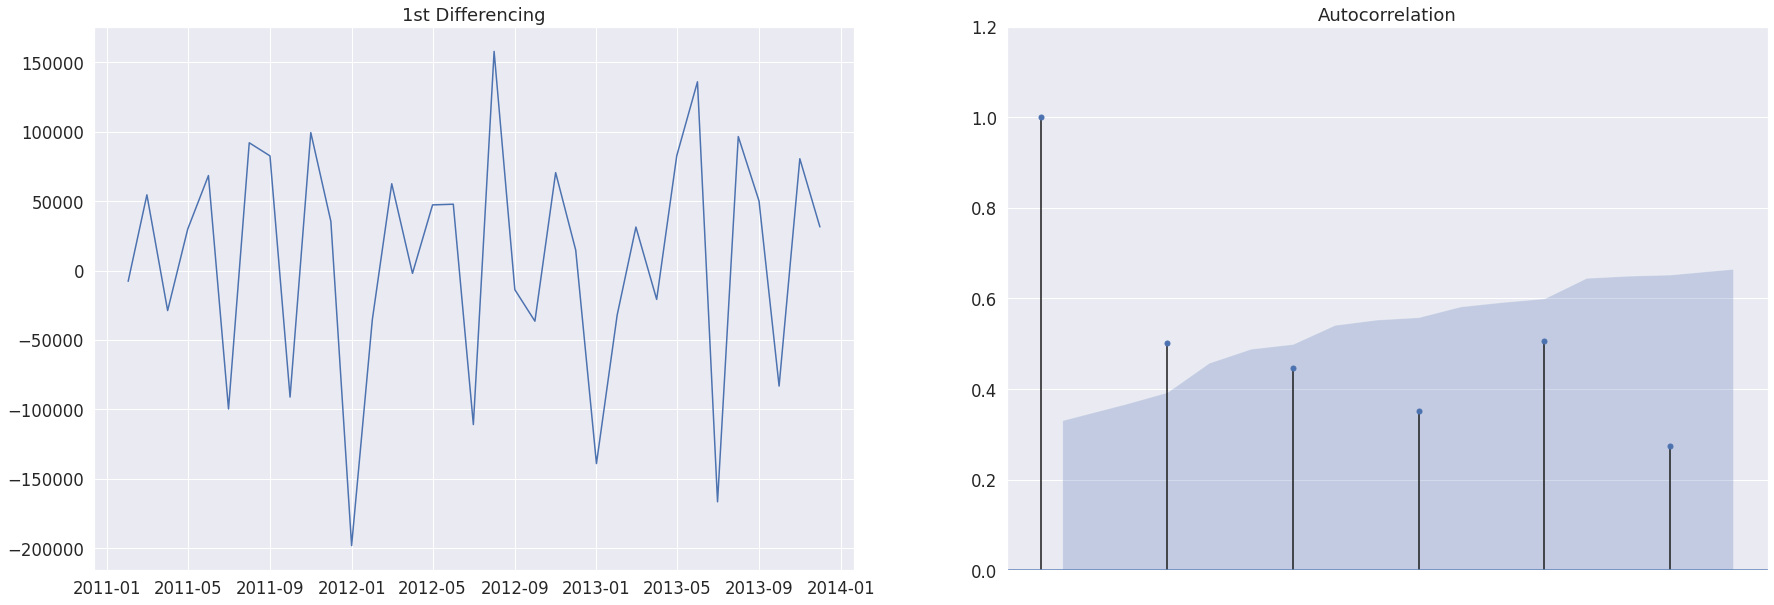

In [40]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(train["Sales"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train["Sales"].diff().dropna(), ax=axes[1])
plt.gcf().set_size_inches(30, 10)
axes[1].set_xticks([])
plt.show()

**Observations:**
- None of the lines are above the blue line by a large amount.  We'll set the MA term q = 0.
- The ARIMA model will be built with terms: p, d, q = 2, 1, 0

Now we will finally fit the Sales time series to an ARIMA model:

In [41]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# order=(p, d, q)
model = ARIMA(train["Sales"], order=(2, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -440.015
Method:                       css-mle   S.D. of innovations          69167.251
Date:                Sun, 12 Dec 2021   AIC                            888.029
Time:                        20:26:57   BIC                            894.250
Sample:                    02-01-2011   HQIC                           890.177
                         - 12-01-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7583.9403   6106.702      1.242      0.223   -4384.976    1.96e+04
ar.L1.D.Sales    -0.4931      0.148     -3.336      0.002      -0.783      -0.203
ar.L2.D.Sales    -0.4632      0.145     

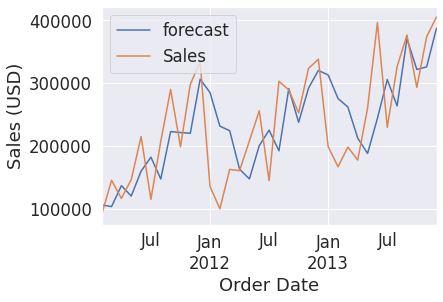

In [42]:
model_fit.plot_predict(dynamic=False)
plt.ylabel("Sales (USD)")
plt.show()

## Using ARIMA for Predictions

The ARIMA model that was manually configured above does a decent job of predicting sales from 2011-2013.  However, we are interested in its ability to predict sales from January 2014 - December 2014.  We are going to use a **walk-forward validation** model, meaning, the ARIMA model will predict one step into the future and have access to all prior historical data.  *In other words, the model will have access to January 2014's actual data when predicting February 2014.*

Speaking from experience, sales predictions very far into the future (e.g. six months) may not be accurate, especially if there is little training data (e.g. only a few years).  

For our monthly total sales data, one step into the future is essentially one month.  Thus, we'll loop across each month in 2014, fit the ARIMA model will all prior data (including 2014 data when relevant), and save predictions to do performance evaluation.

We'll be using RMSE for evaluation.  We're going to use a differenced time series with a lag of 12 because it is clear there is a yearly trend.  We'll need to reverse this difference before calculating the RMSE.  We'll accomplish both of these tasks with the `difference()` and `inverse_difference()` functions we created at the beginning of this notebook.

In [43]:
from sklearn.metrics import mean_squared_error

#Import the test data, format as an array
validation = pd.read_csv('/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/test.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')

#Import the training data, format as an array
dataset = pd.read_csv('/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/train.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')

history = [x for x in X] #Create a list of all training data
months_in_year = 12
predictions=list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, months_in_year)
predictions.append(y[0])
history.append(y[0])
print(f'Predicted: {yhat:.3f}, Expected: {y[0]:.3f}') #output first month's performance

#loop through all months and calculate performance
for i in range(1, len(y)):
	months_in_year = 12
	diff = difference(history, months_in_year) #account for seasonality
	model = ARIMA(diff, order=(2, 1, 0)) #create ARIMA model
	model_fit = model.fit() #fit model
	yhat = model_fit.forecast()[0] #get prediction value
	yhat = inverse_difference(history, yhat, months_in_year) #reverse the difference to get value
	predictions.append(yhat) #add predicted value to list
	# observation
	obs = y[i]
	history.append(obs)
	print('Predicted: %.3f, Expected: %.3f' % (yhat, obs))
 
# report performance
rmse = np.sqrt(mean_squared_error(y, predictions))
print('\nRMSE: %.3f' % rmse)

Predicted: 566635.506, Expected: 241268.562
Predicted: 219572.899, Expected: 184837.359
Predicted: 244164.908, Expected: 263100.781
Predicted: 227059.163, Expected: 242771.859
Predicted: 304519.454, Expected: 288401.031
Predicted: 448965.137, Expected: 401814.062
Predicted: 266812.737, Expected: 258705.688
Predicted: 352870.575, Expected: 456619.938
Predicted: 444324.620, Expected: 481157.250
Predicted: 365634.893, Expected: 422766.625
Predicted: 507682.437, Expected: 555279.000
Predicted: 560255.036, Expected: 503143.688

RMSE: 45891.640


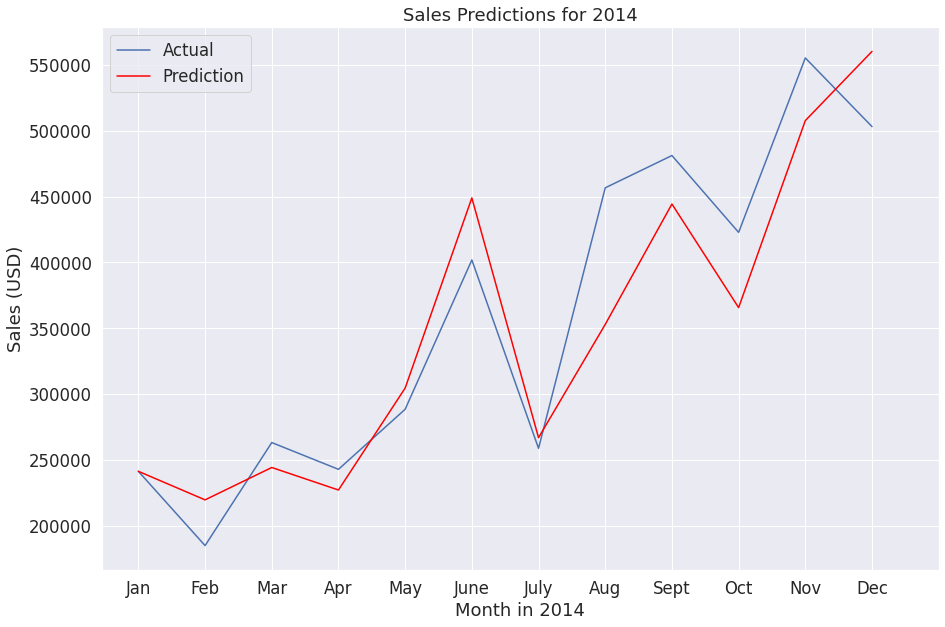

In [44]:
#plot actual versus forecast
plt.plot(y, label="Actual")
plt.plot(predictions, color='red', label="Prediction")

#visuals
plt.title("Sales Predictions for 2014")
plt.xlabel("Month in 2014")
plt.xticks(ticks=np.arange(0,13,1), labels=["Jan", "Feb", "Mar", "Apr", "May", "June", 
                                            "July", "Aug", "Sept", "Oct", "Nov", "Dec"])
plt.ylabel("Sales (USD)")
plt.gcf().set_size_inches(15, 10)
plt.legend(loc="upper left")
plt.show()

## Conclusions and Summary

- We were able to confirm that both `Sales` and `Profit` are increasing each year using rolling averages and frequency plots of `30D` and `MS`, respectively.
- Profit is growing on a lower scale than Sales.
- We were able to accurately model the `Sales` for the year 2014 using an ARIMA model with the order 2, 1, 0 on a time series that had a difference of 12.  We used one-step predictions, meaning February 2014 was predicted using the actual data from January 2014 and all previous sales data.
- The RMSE of our model is 45891.64 USD, which is great considering the scale of `Sales` is to the order of 200,000-500,000 USD.